In [59]:
%matplotlib inline
import sys
import os
import requests
import datetime
import dateutil.parser
import json
import numpy
import pandas
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics

In [2]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)
username = "rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_rknop_passwd" ) ) as ifp:
    password = ifp.readline().strip()

In [3]:
rqs = requests.session()
rqs.get( f'{url}/accounts/login/' )
res = rqs.post( f'{url}/accounts/login/',
                data={ "username": username,
                       "password": password,
                       "csrfmiddlewaretoken": rqs.cookies['csrftoken'] } )
if res.status_code != 200:
    raise RuntimeError( f"Failed to log in; http status: {res.status_code}" )
if 'Please enter a correct' in res.text:
    raise RuntimeError( "Failed to log in.  I think.  Put in a debug break and look at res.text" )
rqs.headers.update( { 'X-CSRFToken': rqs.cookies['csrftoken'] } )

In [4]:
def run_query(query, subdict=None):
    result = rqs.post( f'{url}/db/runsqlquery/',
        json={ 'query': query, 'subdict': subdict } )
    if result.status_code != 200:
        sys.stderr.write( f"ERROR: got status code {result.status_code} ({result.reason})\n" )
    else:
        data = json.loads( result.text )
        if ( 'status' not in data ) or ( data['status'] != 'ok' ):
            sys.stderr.write( "Got unexpected response\n" )
            print(data['error'])
        else:
            return data['rows']

In [5]:
rows = run_query( 'SELECT "classifierId","brokerName","brokerVersion",'
                  '"classifierName","classifierParams" '
                  'FROM elasticc_brokerclassifier' )
classifier_info = {}
for row in rows:
    classifier_info[row["classifierId"]] = row                                 

In [6]:
rows = run_query( 'SELECT DISTINCT ON ("classId") "classId",description '
                  'FROM elasticc_gentypeofclassid '
                  'ORDER BY "classId"' )
classname = {}
for row in rows:
    classname[row["classId"]] = row["description"]

In [9]:
# consider descIngestTimestamp, alertSentTimestamp
#
# alertSentTimestamp -- this gets updated in the database when the original
#    alert is sent out.  It's NOT present in the dev database, but should
#    be in the real one
# descIngestTimestamp -- just when we happend to suck in the broker message
#
# alertId -- opaque fingerprint, don't sort on it, but it does correspond to
#   the original alert.  Different alertId = different source, i.e.
#   measurement of the transient.

sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'ORDER BY "diaObjectId","descIngestTimestamp","classifierId" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data
# classifiers = data.classifierId.unique()

Query start at 2022-10-21T13:12:12.472893...
Query done at 2022-10-21T13:12:13.495602


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp
0,48,1000674,0,2001348001,111,1.000000e+00,2022-09-28T23:30:24.257Z
1,49,1000674,0,2001348001,111,0.000000e+00,2022-09-28T23:30:24.257Z
2,50,1000674,0,2001348001,111,0.000000e+00,2022-09-28T23:30:24.257Z
3,51,1000674,0,2001348001,111,0.000000e+00,2022-09-28T23:30:24.257Z
4,52,1000674,111,2001348001,111,0.000000e+00,2022-09-28T23:30:24.257Z
...,...,...,...,...,...,...,...
95,40,1000674,134,2001348004,111,8.247874e-10,2022-09-29T15:57:57.316Z
96,40,1000674,211,2001348004,111,2.252527e-13,2022-09-29T15:57:57.316Z
97,40,1000674,213,2001348004,111,1.973969e-15,2022-09-29T15:57:57.316Z
98,40,1000674,131,2001348007,111,2.167188e-02,2022-09-29T16:03:30.393Z


In [21]:
classname

{0: 'Static/Other',
 1: 'Non-Recurring',
 2: 'Recurring',
 10: 'Non-Recurring/Other',
 11: 'SN-like',
 12: 'Fast',
 13: 'Long',
 20: 'Recurring/Other',
 21: 'Periodic',
 22: 'Non-Periodic',
 110: 'SN-like/Other',
 111: 'Ia',
 112: 'Ib/c',
 113: 'II',
 114: 'Iax',
 115: '91bg',
 120: 'Fast/Other',
 121: 'KN',
 122: 'M-dwarf Flare',
 123: 'Dwarf Nova',
 124: 'uLens',
 130: 'Long/Other',
 131: 'SLSN',
 132: 'TDE',
 133: 'ILOT',
 134: 'CART',
 135: 'PISN',
 210: 'Periodic/Other',
 211: 'Cepheid',
 212: 'RR Lyrae',
 213: 'Delta Scuti',
 214: 'EB',
 215: 'LPV/Mira',
 220: 'Non-Periodic/Other',
 221: 'AGN'}

In [24]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp","alertSentTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'WHERE "classifierId"=41 AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "diaObjectId","descIngestTimestamp" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-10-21T13:31:18.754312...
Query done at 2022-10-21T13:32:22.744065


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp,alertSentTimestamp
0,41,1013398,111,2026796056,111,4.870162e-02,2022-10-19T13:22:19.752Z,2022-10-18T22:22:06.602Z
1,41,1013449,111,2026898001,111,2.618220e-02,2022-09-30T14:10:42.721Z,2022-09-29T22:20:07.408Z
2,41,1013518,111,2027036013,111,9.470748e-06,2022-10-03T03:45:57.346Z,2022-10-02T20:49:16.726Z
3,41,1013970,111,2027940000,111,1.216396e-04,2022-09-29T20:25:59.092Z,2022-09-28T21:36:18.206Z
4,41,1013970,111,2027940001,111,1.515277e-03,2022-09-29T20:30:43.616Z,2022-09-28T21:36:40.793Z
5,41,1014036,111,2028072013,111,4.597969e-04,2022-10-04T11:19:41.458Z,2022-10-03T23:00:11.275Z
6,41,1014036,111,2028072014,111,2.885710e-03,2022-10-04T11:24:21.992Z,2022-10-03T23:00:30.855Z
7,41,1014036,111,2028072016,111,1.399223e-03,2022-10-04T23:02:00.931Z,2022-10-04T20:27:51.687Z
8,41,1014036,111,2028072017,111,3.307451e-05,2022-10-05T04:17:46.455Z,2022-10-04T20:54:29.248Z
9,41,1014036,111,2028072018,111,5.443993e-04,2022-10-05T04:25:04.879Z,2022-10-04T20:54:52.701Z


In [15]:
data[ data['diaObjectId'] == 1025381 ]

,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp
87,41,1025381,111,2050762015,111,0.003743,2022-10-05T13:17:27.692Z
88,41,1025381,111,2050762021,111,0.000004,2022-10-06T02:39:17.699Z
89,41,1025381,111,2050762022,111,0.050989,2022-10-07T05:38:50.502Z
90,41,1025381,111,2050762024,111,0.124269,2022-10-07T05:54:40.871Z
91,41,1025381,111,2050762026,111,0.098914,2022-10-07T09:51:58.194Z
92,41,1025381,111,2050762028,111,0.465438,2022-10-07T17:12:09.610Z
93,41,1025381,111,2050762029,111,0.548965,2022-10-07T17:18:30.270Z
94,41,1025381,111,2050762031,111,0.769063,2022-10-07T18:17:07.552Z
95,41,1025381,111,2050762033,111,0.147719,2022-10-07T18:23:26.406Z
96,41,1025381,111,2050762044,111,0.953185,2022-10-19T14:42:21.008Z


In [38]:
# All these joins suggest we need a new view.
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai" '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'WHERE v."diaObjectId"=1025381 AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "classifierId","alertSentTimestamp" ' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-10-21T13:40:42.688033...
Query done at 2022-10-21T13:40:42.917951


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,alertSentTimestamp,midPointTai
0,38,1025381,111,2050762026,111,0.002695,2022-10-07T02:56:40.112Z,60372.3544
1,38,1025381,111,2050762028,111,0.000863,2022-10-07T03:47:25.483Z,60375.3393
2,38,1025381,111,2050762029,111,0.000516,2022-10-07T03:48:04.599Z,60375.3589
3,38,1025381,111,2050762030,111,0.000630,2022-10-07T04:01:05.241Z,60376.2459
4,38,1025381,111,2050762031,111,0.000632,2022-10-07T04:01:05.957Z,60376.2463
5,38,1025381,111,2050762032,111,0.000615,2022-10-07T04:02:15.639Z,60376.2707
6,38,1025381,111,2050762033,111,0.000608,2022-10-07T04:02:16.367Z,60376.2712
7,38,1025381,111,2050762035,111,0.000526,2022-10-07T04:58:53.464Z,60379.2800
8,38,1025381,111,2050762036,111,0.000540,2022-10-07T04:59:49.096Z,60379.3016
9,38,1025381,111,2050762037,111,0.001363,2022-10-07T05:00:36.777Z,60379.3258


In [39]:
pandas.set_option('display.max_rows', 500)
data['t'] = data['alertSentTimestamp'].apply( lambda thing : dateutil.parser.isoparse( thing ) )
data.columns


Index(['classifierId', 'diaObjectId', 'classId', 'alertId', 'trueClassId',
       'probability', 'alertSentTimestamp', 'midPointTai', 't'],
      dtype='object')

In [46]:
classifier_info

{36: {'classifierId': 36,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuess',
  'classifierParams': 'XGBUnified+Parsnip04'},
 37: {'classifierId': 37,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLive',
  'classifierParams': 'XGBUnified+Parsnip04'},
 38: {'classifierId': 38,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnip',
  'classifierParams': 'XGBUnified+Parsnip04'},
 39: {'classifierId': 39,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnipPrior',
  'classifierParams': 'XGBUnified+Parsnip04'},
 40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 41: {'classifierId': 41,
  'brokerName': 'ALeRCE',
  'brokerVersion': '1.0.0',
  'classifierName': 'messi',
  'classifierParams': '1.0.0'},
 42: {'classifierId': 42,
  'broke

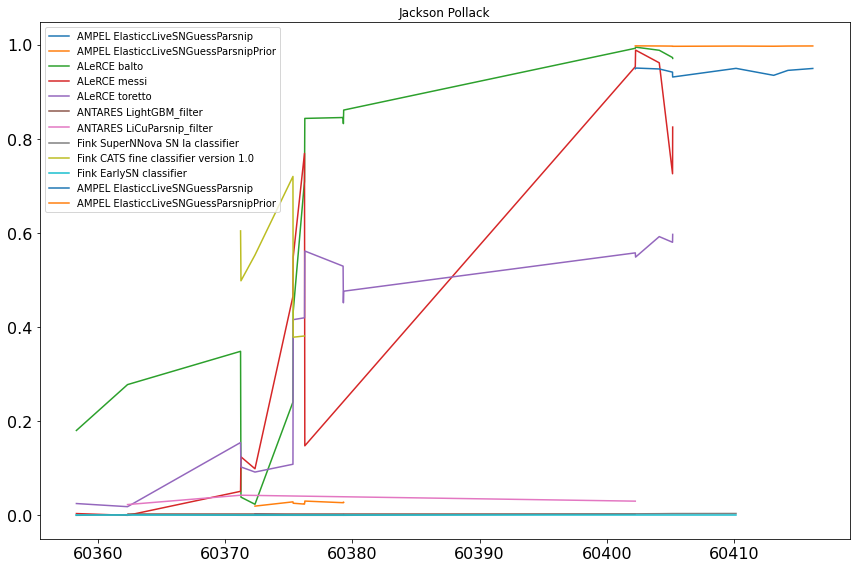

In [48]:
fig = plt.figure( figsize=(12,8), tight_layout=True )
ax = fig.add_subplot( 1,1,1)
classifiers = data['classifierId'].unique()
for i,cfer in enumerate(classifiers):
    subdata = data[ data['classifierId'] == cfer ]
    label = f'{classifier_info[cfer]["brokerName"]} {classifier_info[cfer]["classifierName"]}'
    ax.plot( subdata['midPointTai'], subdata['probability'], color=f'C{i}', label=label )
    ax.tick_params( "both", labelsize=16 )
ax.legend()
ax.set_title( "Jackson Pollack" )
fig.show()

In [50]:
# Oh, the humanity
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai",t.peakmjd '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'INNER JOIN elasticc_diaobjecttruth t ON v."diaObjectId"=t."diaObjectId" '
          'WHERE v."diaObjectId" IN '
          '  ( SELECT "diaObjectId" FROM elasticc_diaobjecttruth WHERE gentype IN '
          '     ( SELECT gentype FROM elasticc_gentypeofclassid WHERE "classId"=111 ) '
          '    LIMIT 100 ) '
          'AND "classId"=111 '
          'ORDER BY "classifierId","alertSentTimestamp" ' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-10-21T14:05:29.485372...
Query done at 2022-10-21T14:08:38.588324


,classifierId,diaObjectId,classId,alertId,probability,alertSentTimestamp,midPointTai,peakmjd
0,38,15679692,111,31359384009,0.000075,2022-09-29T21:54:56.803Z,60292.0926,60291.192
1,38,15679692,111,31359384010,0.000089,2022-09-29T21:55:01.887Z,60292.0940,60291.192
2,38,15679692,111,31359384011,0.000093,2022-09-29T22:33:59.647Z,60296.1635,60291.192
3,38,15679692,111,31359384012,0.000130,2022-09-29T22:34:42.909Z,60296.1874,60291.192
4,38,15679692,111,31359384019,0.000160,2022-10-01T20:23:08.891Z,60312.0607,60291.192
...,...,...,...,...,...,...,...,...
1529,66,11114646,111,22229292080,0.058215,2022-10-19T23:35:10.899Z,60417.0442,60371.305
1530,66,132454456,111,264908912046,0.970512,2022-10-19T23:39:05.923Z,60417.1256,60398.266
1531,66,11114646,111,22229292086,0.051745,2022-10-20T21:17:35.169Z,60424.0955,60371.305
1532,66,11114646,111,22229292093,0.057549,2022-10-20T21:44:57.353Z,60426.0943,60371.305


In [51]:
data['Δt'] = data['midPointTai'] - data['peakmjd']
data

,classifierId,diaObjectId,classId,alertId,probability,alertSentTimestamp,midPointTai,peakmjd,Δt
0,38,15679692,111,31359384009,0.000075,2022-09-29T21:54:56.803Z,60292.0926,60291.192,0.9006
1,38,15679692,111,31359384010,0.000089,2022-09-29T21:55:01.887Z,60292.0940,60291.192,0.9020
2,38,15679692,111,31359384011,0.000093,2022-09-29T22:33:59.647Z,60296.1635,60291.192,4.9715
3,38,15679692,111,31359384012,0.000130,2022-09-29T22:34:42.909Z,60296.1874,60291.192,4.9954
4,38,15679692,111,31359384019,0.000160,2022-10-01T20:23:08.891Z,60312.0607,60291.192,20.8687
...,...,...,...,...,...,...,...,...,...
1529,66,11114646,111,22229292080,0.058215,2022-10-19T23:35:10.899Z,60417.0442,60371.305,45.7392
1530,66,132454456,111,264908912046,0.970512,2022-10-19T23:39:05.923Z,60417.1256,60398.266,18.8596
1531,66,11114646,111,22229292086,0.051745,2022-10-20T21:17:35.169Z,60424.0955,60371.305,52.7905
1532,66,11114646,111,22229292093,0.057549,2022-10-20T21:44:57.353Z,60426.0943,60371.305,54.7893


In [62]:
onebroker = data[ data['classifierId'] == 40 ].copy()

In [63]:
onebroker

,classifierId,diaObjectId,classId,alertId,probability,alertSentTimestamp,midPointTai,peakmjd,Δt
180,40,15679692,111,31359384000,1.767502e-02,2022-09-28T21:19:43.858Z,60283.1507,60291.192,-8.0413
181,40,15679692,111,31359384001,3.753373e-02,2022-09-28T21:20:36.947Z,60283.1751,60291.192,-8.0169
182,40,15679692,111,31359384002,4.302558e-03,2022-09-29T21:14:41.408Z,60288.1145,60291.192,-3.0775
183,40,15679692,111,31359384003,5.863833e-02,2022-09-29T21:15:34.361Z,60288.1392,60291.192,-3.0528
184,40,15679692,111,31359384004,9.403486e-02,2022-09-29T21:45:56.215Z,60291.1590,60291.192,-0.0330
185,40,15679692,111,31359384005,8.421218e-02,2022-09-29T21:46:43.358Z,60291.1831,60291.192,-0.0089
186,40,97189989,111,194379978020,5.423236e-02,2022-09-29T21:48:20.443Z,60291.2341,60296.513,-5.2789
187,40,15679692,111,31359384010,3.536645e-01,2022-09-29T21:55:01.887Z,60292.0940,60291.192,0.9020
188,40,97189989,111,194379978025,7.495632e-01,2022-09-29T21:55:53.576Z,60292.2614,60296.513,-4.2516
189,40,83609725,111,167219450002,1.488231e-02,2022-09-29T22:05:25.182Z,60293.3537,60284.350,9.0037


(array([14., 31., 40., 29., 10., 26., 12.,  3.,  4.,  7.]),
 array([-16.9076,  -8.7495,  -0.5914,   7.5667,  15.7248,  23.8829,
         32.041 ,  40.1991,  48.3572,  56.5153,  64.6734]),
 <BarContainer object of 10 artists>)

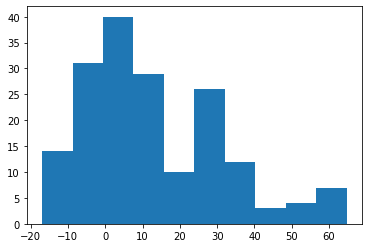

In [64]:
plt.hist( onebroker['Δt'] )

In [65]:
# This is not the right way to bin.  We have to think harder about this.
# If there are more observations of some objectds, those objects will
# get overweighted.
onebroker['tbin'] = numpy.floor( ( onebroker['Δt'] + 20 ) / 5. )

In [69]:
thing = onebroker.groupby( 'tbin' )['probability'].apply( 'mean' )

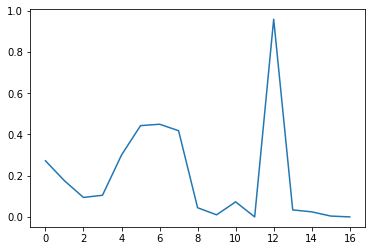

In [73]:
plt.plot(thing)